<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/Final_LSTM_Team_Project_MSI_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Team Project
## By changes parameter setting you create, train and predict an array of model to predict stocks.



#Code Section

In [13]:
pip install pandas_ta

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [15]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [16]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [17]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#XOM
Ticker = ['MSI']
frame_days = [75]
LSTM_layers = [1,2,3,4,5]



Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 5 models


In [18]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L1___________
Start Time:2024-05-01 01:27:46.455063
Epoch 1/30
119/119 - 19s - loss: 0.0045 - mae: 0.0513 - val_loss: 0.0323 - val_mae: 0.1438 - 19s/epoch - 162ms/step
Epoch 2/30
119/119 - 8s - loss: 0.0047 - mae: 0.0482 - val_loss: 0.0891 - val_mae: 0.2673 - 8s/epoch - 65ms/step
Epoch 3/30
119/119 - 7s - loss: 0.0031 - mae: 0.0416 - val_loss: 0.0727 - val_mae: 0.2379 - 7s/epoch - 62ms/step
Epoch 4/30
119/119 - 7s - loss: 0.0025 - mae: 0.0381 - val_loss: 0.0594 - val_mae: 0.2076 - 7s/epoch - 56ms/step
Epoch 5/30
119/119 - 4s - loss: 0.0033 - mae: 0.0442 - val_loss: 0.0462 - val_mae: 0.1791 - 4s/epoch - 32ms/step
Epoch 6/30
119/119 - 3s - loss: 0.0043 - mae: 0.0518 - val_loss: 0.0344 - val_mae: 0.1512 - 3s/epoch - 27ms/step
Epoch 7/30
119/119 - 3s - loss: 0.0043 - mae: 0.0503 - val_loss: 0.0254 - val_mae: 0.1278 - 3s/epoch - 27ms/step
Epoch 8/30
119/119 - 5s - loss: 0.0033 - mae: 0.0451 - val_loss: 0.0212 - val_mae: 0.1168 - 5s/epoch - 39ms/step
Epoch 9/30
119/119 - 3

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L2___________
Start Time:2024-05-01 01:30:18.662530
Epoch 1/30
119/119 - 13s - loss: 0.0020 - mae: 0.0352 - val_loss: 0.1000 - val_mae: 0.2836 - 13s/epoch - 109ms/step
Epoch 2/30
119/119 - 10s - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0494 - val_mae: 0.1857 - 10s/epoch - 80ms/step
Epoch 3/30
119/119 - 7s - loss: 0.0049 - mae: 0.0448 - val_loss: 0.0637 - val_mae: 0.2140 - 7s/epoch - 59ms/step
Epoch 4/30
119/119 - 9s - loss: 0.0041 - mae: 0.0444 - val_loss: 0.0635 - val_mae: 0.2137 - 9s/epoch - 76ms/step
Epoch 5/30
119/119 - 8s - loss: 0.0046 - mae: 0.0441 - val_loss: 0.0874 - val_mae: 0.2641 - 8s/epoch - 68ms/step
Epoch 6/30
119/119 - 7s - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0756 - val_mae: 0.2430 - 7s/epoch - 57ms/step
Epoch 7/30
119/119 - 8s - loss: 0.0023 - mae: 0.0353 - val_loss: 0.0780 - val_mae: 0.2493 - 8s/epoch - 69ms/step
Epoch 8/30
119/119 - 7s - loss: 0.0019 - mae: 0.0349 - val_loss: 0.0759 - val_mae: 0.2439 - 7s/epoch - 57ms/step
Epoch 9/30
119/119 -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L3___________
Start Time:2024-05-01 01:34:48.078930
Epoch 1/30
119/119 - 19s - loss: 0.0017 - mae: 0.0329 - val_loss: 0.1442 - val_mae: 0.3444 - 19s/epoch - 160ms/step
Epoch 2/30
119/119 - 12s - loss: 0.0025 - mae: 0.0301 - val_loss: 0.1502 - val_mae: 0.3523 - 12s/epoch - 102ms/step
Epoch 3/30
119/119 - 11s - loss: 0.0031 - mae: 0.0317 - val_loss: 0.1698 - val_mae: 0.3832 - 11s/epoch - 96ms/step
Epoch 4/30
119/119 - 12s - loss: 0.0030 - mae: 0.0352 - val_loss: 0.1636 - val_mae: 0.3735 - 12s/epoch - 102ms/step
Epoch 5/30
119/119 - 10s - loss: 0.0033 - mae: 0.0369 - val_loss: 0.1550 - val_mae: 0.3612 - 10s/epoch - 88ms/step
Epoch 6/30
119/119 - 13s - loss: 0.0033 - mae: 0.0369 - val_loss: 0.1503 - val_mae: 0.3571 - 13s/epoch - 107ms/step
Epoch 7/30
119/119 - 11s - loss: 0.0036 - mae: 0.0409 - val_loss: 0.1150 - val_mae: 0.3046 - 11s/epoch - 95ms/step
Epoch 8/30
119/119 - 13s - loss: 0.0043 - mae: 0.0411 - val_loss: 0.0886 - val_mae: 0.2574 - 13s/epoch - 106ms/step
Epoc

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L4___________
Start Time:2024-05-01 01:41:18.884480
Epoch 1/30
119/119 - 27s - loss: 0.0012 - mae: 0.0262 - val_loss: 0.1447 - val_mae: 0.3494 - 27s/epoch - 229ms/step
Epoch 2/30
119/119 - 17s - loss: 0.0032 - mae: 0.0340 - val_loss: 0.1933 - val_mae: 0.4119 - 17s/epoch - 139ms/step
Epoch 3/30
119/119 - 15s - loss: 0.0029 - mae: 0.0336 - val_loss: 0.1808 - val_mae: 0.3971 - 15s/epoch - 128ms/step
Epoch 4/30
119/119 - 15s - loss: 0.0032 - mae: 0.0370 - val_loss: 0.1789 - val_mae: 0.3938 - 15s/epoch - 127ms/step
Epoch 5/30
119/119 - 15s - loss: 0.0032 - mae: 0.0353 - val_loss: 0.1864 - val_mae: 0.4024 - 15s/epoch - 128ms/step
Epoch 6/30
119/119 - 15s - loss: 0.0032 - mae: 0.0343 - val_loss: 0.1836 - val_mae: 0.3985 - 15s/epoch - 125ms/step
Epoch 7/30
119/119 - 15s - loss: 0.0040 - mae: 0.0394 - val_loss: 0.1270 - val_mae: 0.3230 - 15s/epoch - 128ms/step
Epoch 8/30
119/119 - 15s - loss: 0.0045 - mae: 0.0422 - val_loss: 0.1568 - val_mae: 0.3641 - 15s/epoch - 127ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L5___________
Start Time:2024-05-01 01:49:57.156671
Epoch 1/30
119/119 - 33s - loss: 0.0012 - mae: 0.0249 - val_loss: 0.1448 - val_mae: 0.3469 - 33s/epoch - 275ms/step
Epoch 2/30
119/119 - 20s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.1832 - val_mae: 0.3986 - 20s/epoch - 171ms/step
Epoch 3/30
119/119 - 19s - loss: 0.0035 - mae: 0.0345 - val_loss: 0.1861 - val_mae: 0.4037 - 19s/epoch - 161ms/step
Epoch 4/30
119/119 - 18s - loss: 0.0033 - mae: 0.0376 - val_loss: 0.2204 - val_mae: 0.4339 - 18s/epoch - 154ms/step
Epoch 5/30
119/119 - 20s - loss: 0.0035 - mae: 0.0367 - val_loss: 0.2008 - val_mae: 0.4168 - 20s/epoch - 166ms/step
Epoch 6/30
119/119 - 19s - loss: 0.0032 - mae: 0.0338 - val_loss: 0.2060 - val_mae: 0.4230 - 19s/epoch - 156ms/step
Epoch 7/30
119/119 - 18s - loss: 0.0039 - mae: 0.0398 - val_loss: 0.1523 - val_mae: 0.3599 - 18s/epoch - 154ms/step
Epoch 8/30
119/119 - 19s - loss: 0.0047 - mae: 0.0469 - val_loss: 0.0956 - val_mae: 0.2706 - 19s/epoch - 163ms/step
E

In [19]:
#SaveDataToCSV(model_list,'XOM')

# Report Section

In [20]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: MSI_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.10007480607315455
             mean_sqr_err =0.016432645770507532
        root_mean_sqr_err =0.1281898817009655
           pred_diff_mean =0.9083328508806856
      pred_diff_bias_mean =0.09166714911931434
    pred_correctness_mean =0.759009009009009
                      AIC =-1742.1674851878968

############################################################################
  Model Setup:
                    Name: MSI_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
        

############################################################################
  Model Setup:
                    Name: MSI_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.10007480607315455
             mean_sqr_err =0.016432645770507532
        root_mean_sqr_err =0.1281898817009655
           pred_diff_mean =0.9083328508806856
      pred_diff_bias_mean =0.09166714911931434
    pred_correctness_mean =0.759009009009009
                      AIC =-1742.1674851878968



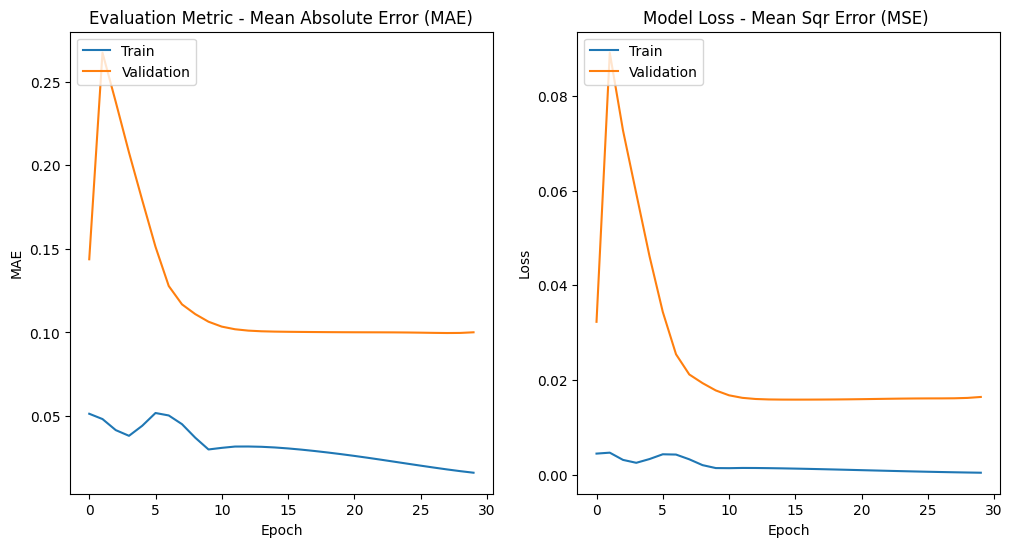

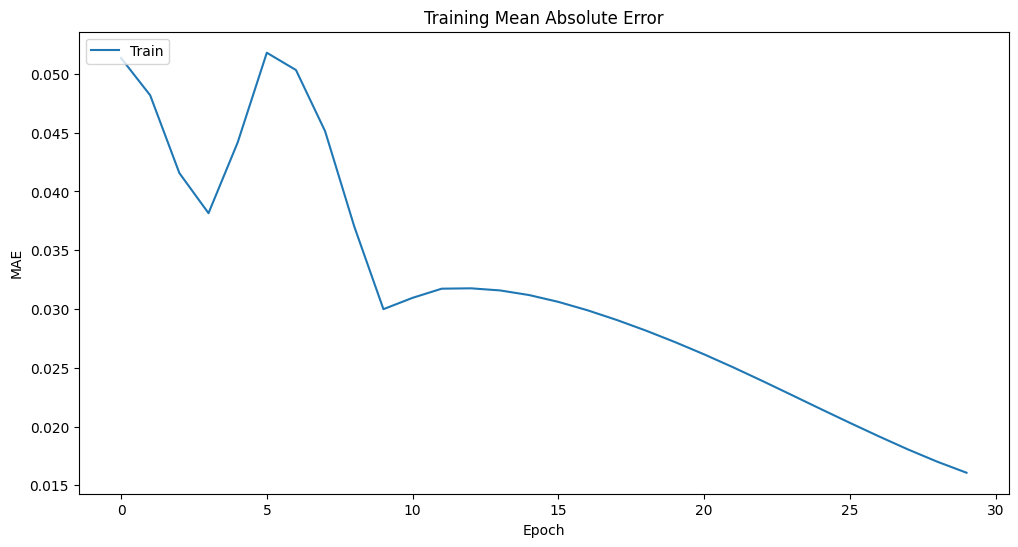

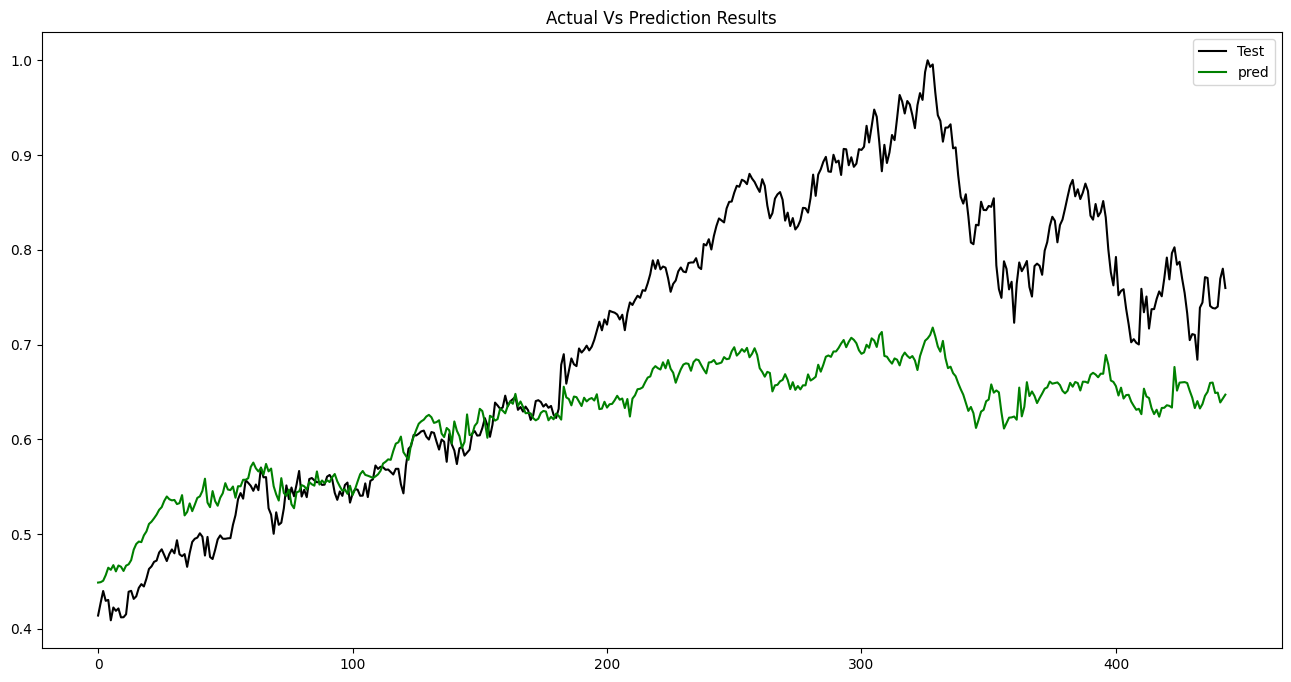

############################################################################
  Model Setup:
                    Name: MSI_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.12124908070006464
             mean_sqr_err =0.023210461572222466
        root_mean_sqr_err =0.1523498000399819
           pred_diff_mean =0.894960599562777
      pred_diff_bias_mean =0.10503940043722297
    pred_correctness_mean =0.7522522522522522
                      AIC =-1588.8395644172854



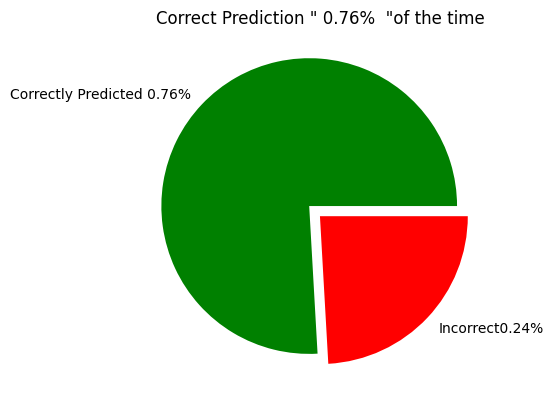

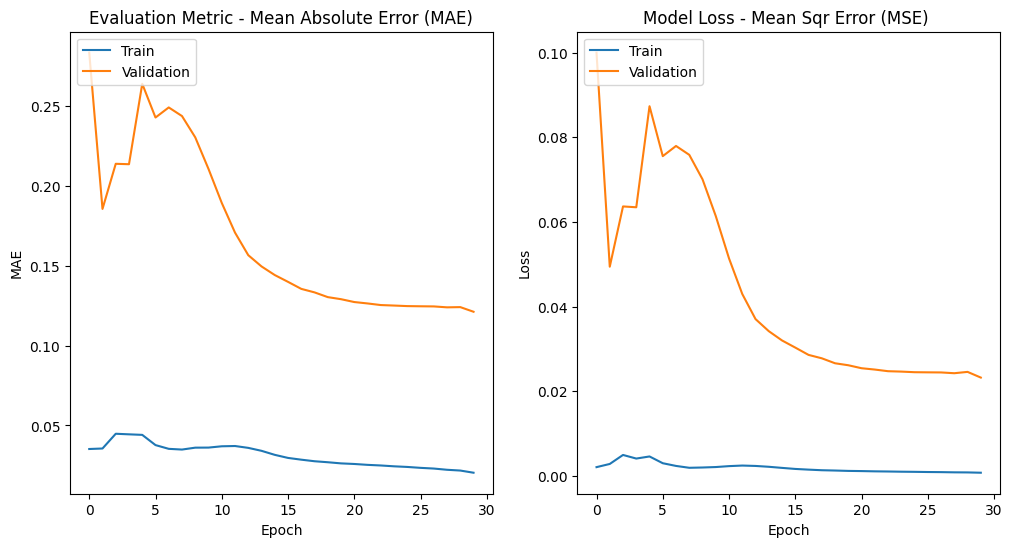

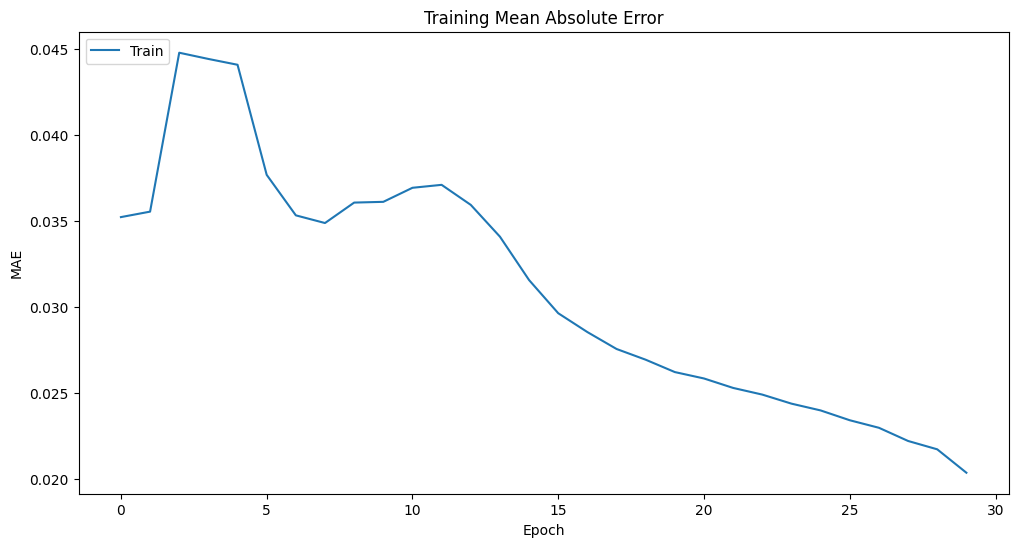

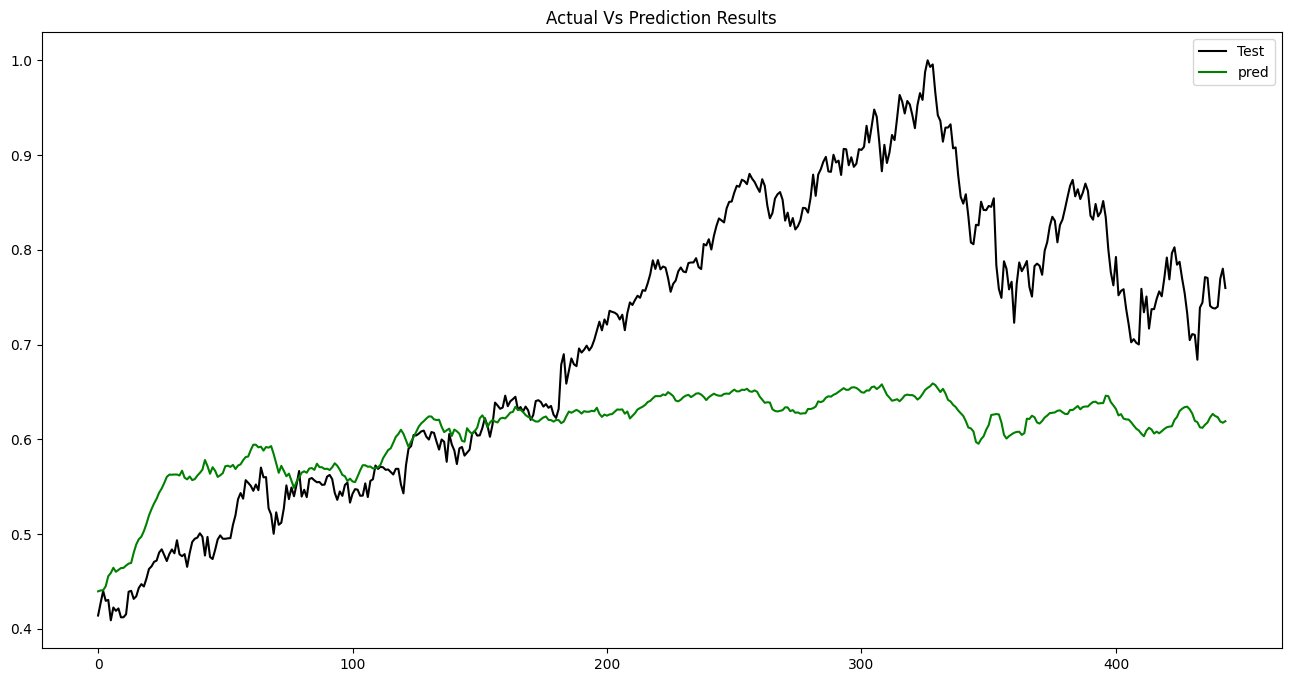

############################################################################
  Model Setup:
                    Name: MSI_F75_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.1908410821205068
             mean_sqr_err =0.05339893511423435
        root_mean_sqr_err =0.2310820960486432
           pred_diff_mean =0.7844081985123246
      pred_diff_bias_mean =0.21559180148767543
    pred_correctness_mean =0.4774774774774775
                      AIC =-1218.904226853749



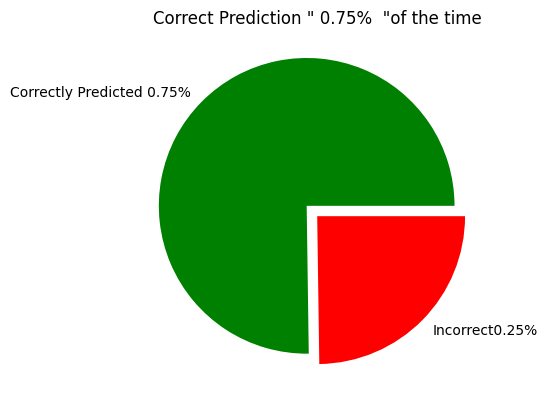

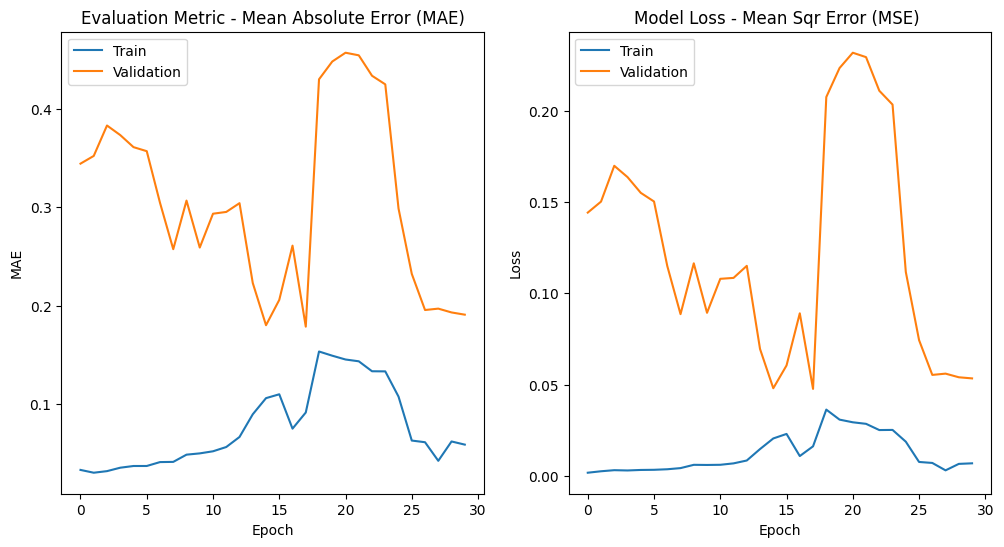

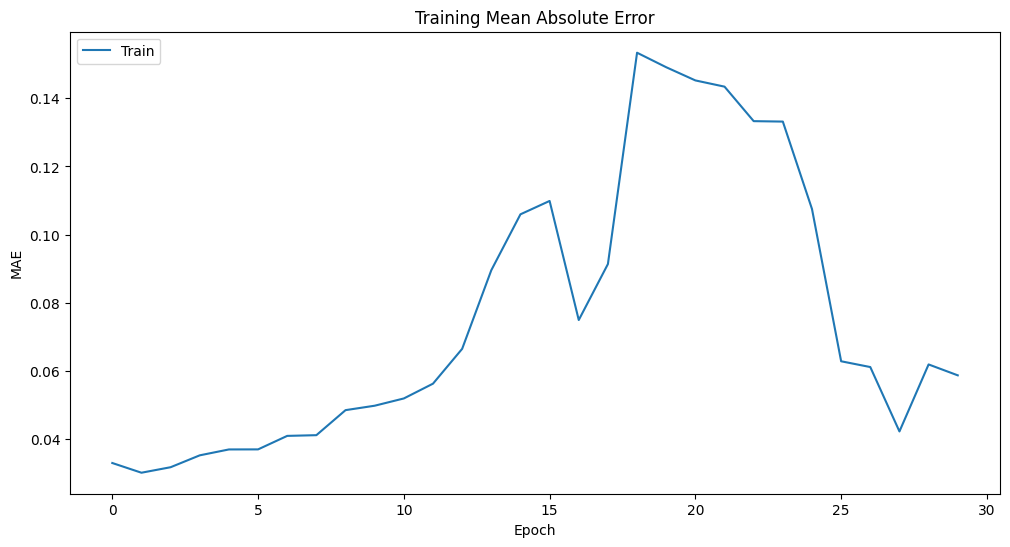

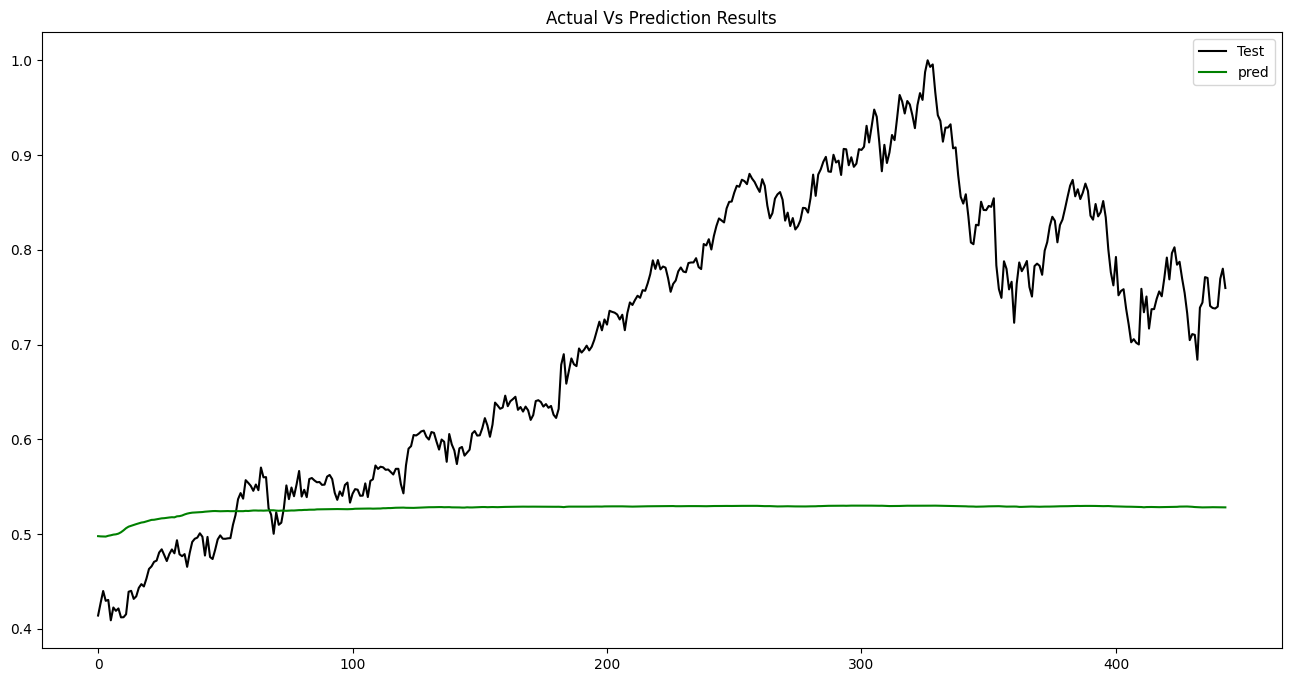

############################################################################
  Model Setup:
                    Name: MSI_F75_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.4770301321318103
             mean_sqr_err =0.2502813212590998
        root_mean_sqr_err =0.5002812421619461
           pred_diff_mean =0.3402975675206431
      pred_diff_bias_mean =0.6597024324793569
    pred_correctness_mean =0.23648648648648649
                      AIC =-533.015350681505



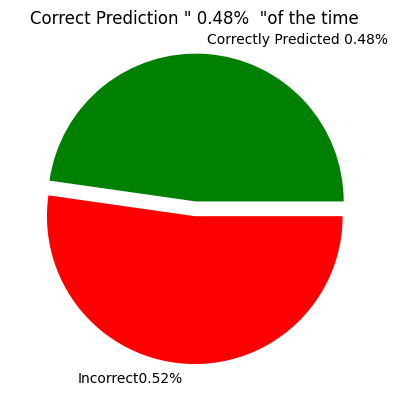

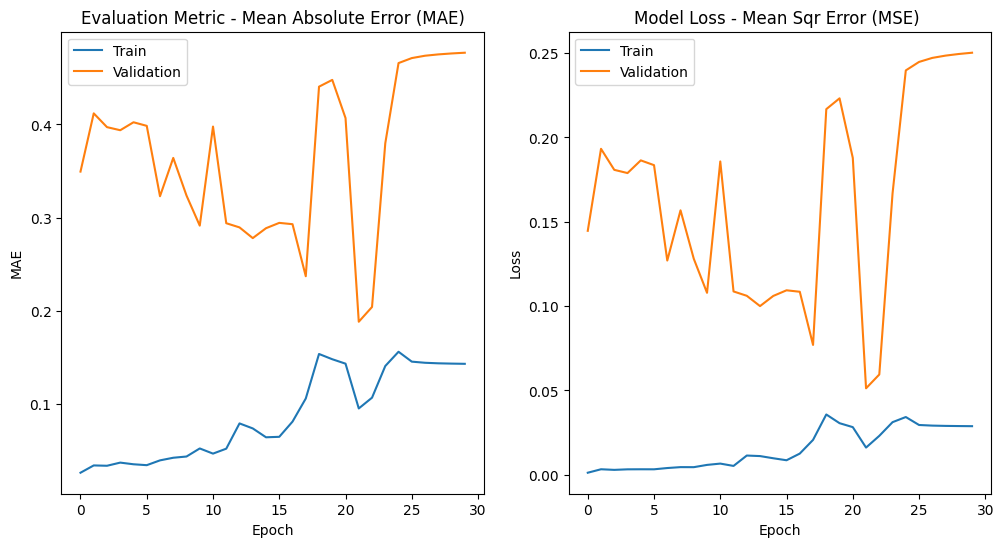

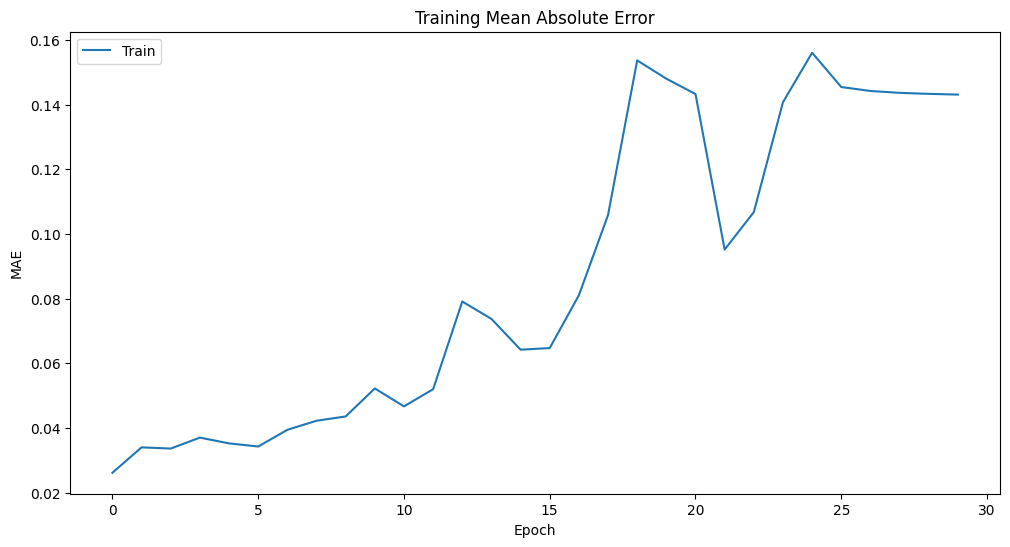

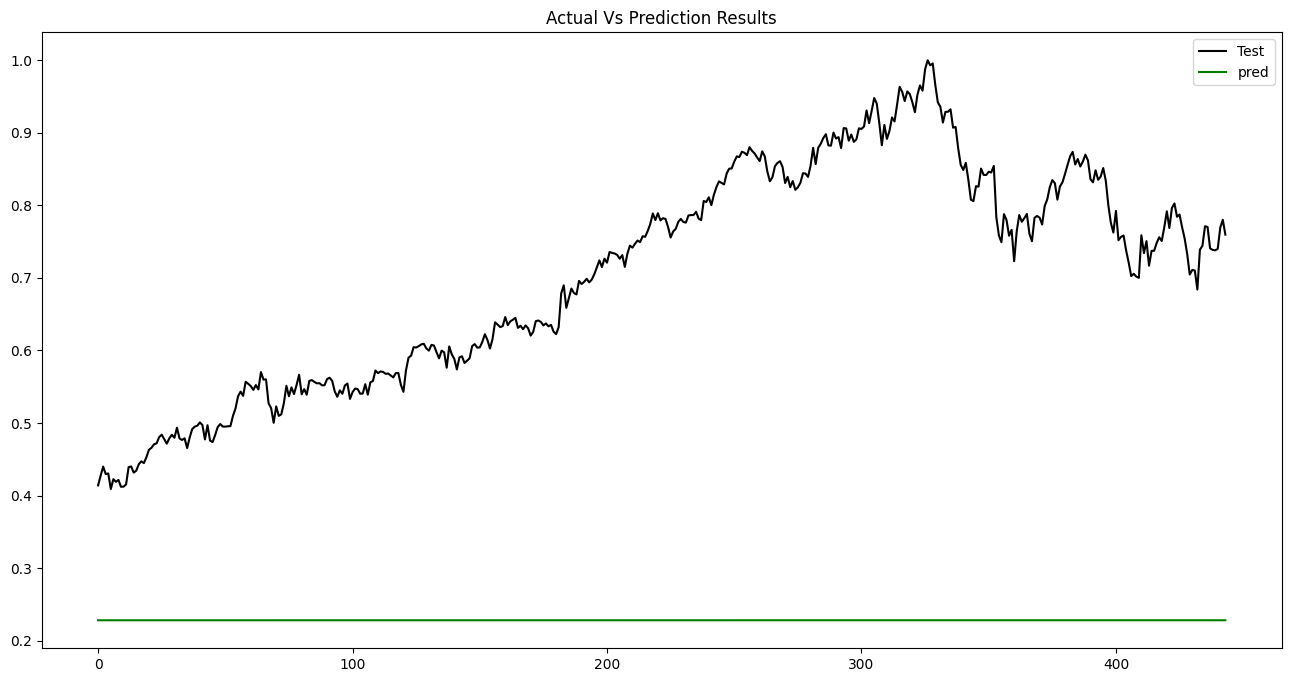

############################################################################
  Model Setup:
                    Name: MSI_F75_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.47373881788217015
             mean_sqr_err =0.2471549414023761
        root_mean_sqr_err =0.4971468006558788
           pred_diff_mean =0.3452104833916239
      pred_diff_bias_mean =0.6547895166083761
    pred_correctness_mean =0.23648648648648649
                      AIC =-538.5964915765916



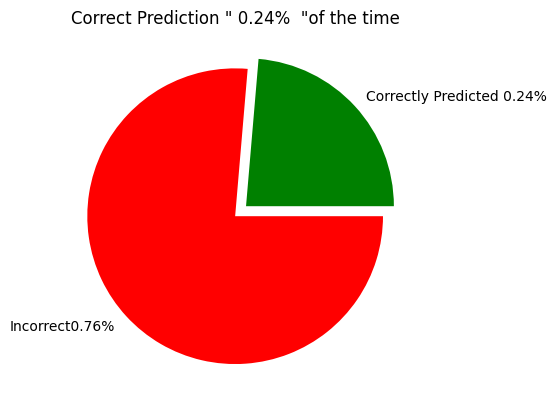

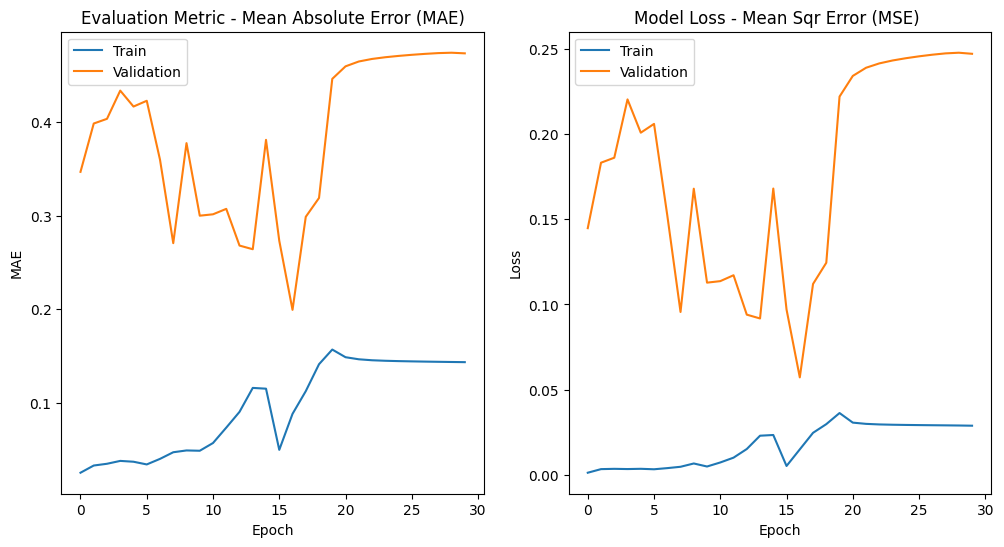

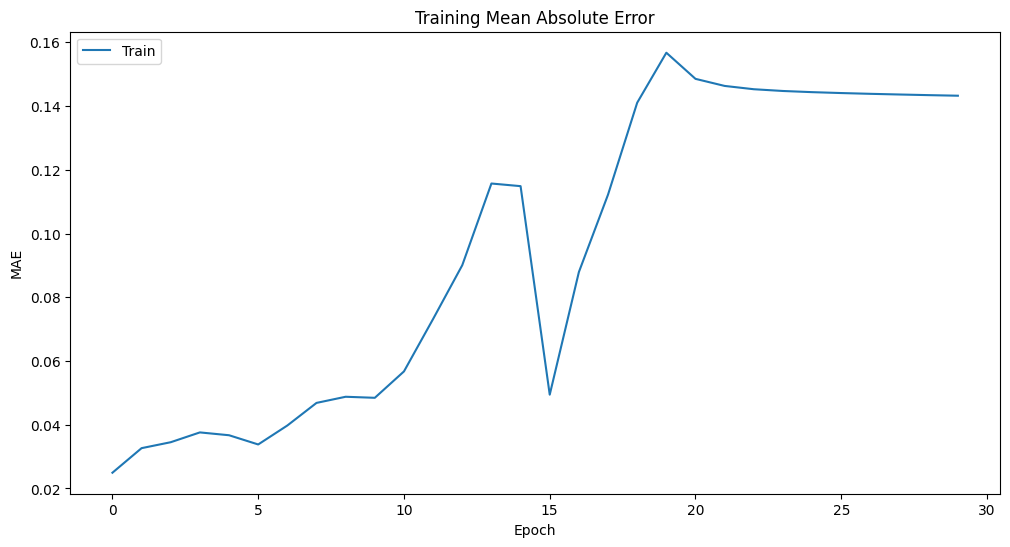

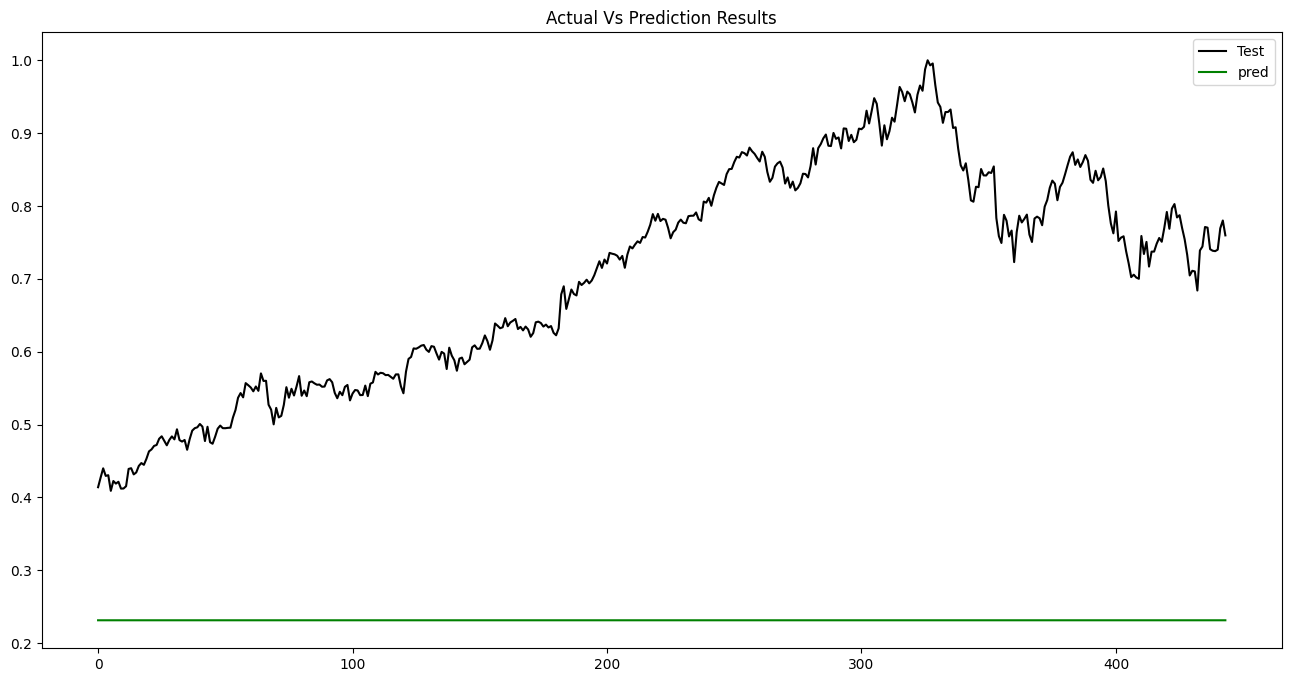

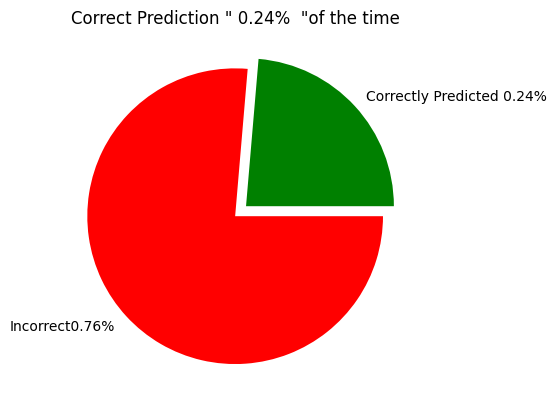

In [21]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [22]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive